<a href="https://colab.research.google.com/github/DannyRoss123/AIXHW6/blob/main/AIXHW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**AIX HW6: Unpacking Mechanistic Interpretability in a Simplified Transformer**

For this project, I’m diving into ideas from the paper *"A Mathematical Framework for Transformer Circuits"*, where the authors break down a toy, one-layer attention-only transformer model. One of the takeaways is how they extract and analyze the OV (output value matrix) to understand how information flows through the model’s residual stream. My plan is to compute the Singular Value Decomposition of this OV matrix and then interpret what the low-rank structure reveals about the model’s inner workings.

I chose this focus because it strikes a great balance between being conceptually rich and practically manageable. Working with a simplified transformer lets me see the mechanics at play without getting lost in the full complexity of larger models. Plus, understanding the OV matrix seems key to grasping how these models “copy” or transmit information—a foundational idea that could inform more advanced research down the line.

**Plan for Implementation:**
1. **Model Setup:** I’ll start with a simplified, one-layer attention-only transformer.
2. **Matrix Extraction:** I’ll identify and pull out the OV matrix from one of the attention heads
3. **SVD Analysis:**  I’ll compute the SVD of the OV matrix.
4. **Visualization:** I plan to plot the singular values to observe their decay and get a sense of the dominant structures.
5. **Interpretation:** Finally, I’ll discuss how these findings relate to the overall behavior of the transformer, tying back to the principles of mechanistic interpretability.

This project is not only an opportunity to get hands-on with transformer internals but also to appreciate how a scaled-down model can offer deep insights into a model’s fundamental behavior.



**Imports and model**

The first step in this process is to import the necessary libraries and load a one-layer attention-only transformer using TransformerLens. This framework allows us to analyze the internal structure of the model, making it easier to extract key components like the OV matrix for further interpretation.

In [ ]:
pip install transformer-lens


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00


In [ ]:
import transformer_lens

# Define a small transformer model with 1 attention layer and no MLP
cfg = transformer_lens.EasyTransformerConfig(
    d_model=128,  # Model size
    n_heads=4,  # Number of attention heads
    d_head=32,  # Head dimension
    n_layers=1,  # One attention layer
    n_ctx=128,  # Context length
    d_vocab=50257,  # Same as GPT-2 vocab
    attn_only=True,  # No MLP, just attention
    seed=42
)

# Initialize the model
model = transformer_lens.EasyTransformer(cfg)                   #Modified from Claude AI at 8:22 pm 2/17/25

# Print model architecture
print(model)


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (ln_final): LayerNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (unembed): Unembed()
)


**OV CIRCUIT**  

The next step is to extract the OV circuits for the attention heads. These circuits help us understand how information flows through the transformer by mapping key-value interactions to output representations. Once extracted, we visualize the shape of the OV matrix to ensure it aligns with our expectations, verifying that the model's structure is consistent with the theoretical framework outlined in the paper.

In [ ]:
# Get the OV circuits for the attention heads
OV_circuit = model.W_O @ model.W_V                  #From Claude AI at 8:45 2/17/2025

print("Shape of OV Circuit:", OV_circuit.shape)  # Should be (n_layers, n_heads, d_model, d_model)


Shape of OV Circuit: torch.Size([1, 4, 32, 32])


As we can see from the output, the size of the OV circuit matches what we would expect to see based on the transformer structure.

**COMPUTE SVD**

Next, we perform Singular Value Decomposition on the OV matrix. This decomposition helps us analyze the underlying structure of the matrix by breaking it down into its singular vectors and singular values. By doing this, we can identify the most significant directions in which information is preserved and transformed within the model, providing insights into how the attention mechanism operates at a fundamental level.

In [ ]:
import torch

# Extract OV matrix for the first layer, first head
OV_matrix = OV_circuit[0, 0]  # First layer, first head

# Perform SVD
U, S, Vt = torch.svd(OV_matrix)                                  #From Claude AI at 9:00 2/17/2025

# Print singular values
print("Singular Values:", S)


Singular Values: tensor([0.6009, 0.5852, 0.5172, 0.5038, 0.4857, 0.4727, 0.4194, 0.4011, 0.3671,
        0.3617, 0.3372, 0.2995, 0.2882, 0.2686, 0.2520, 0.2463, 0.2375, 0.2133,
        0.2074, 0.1857, 0.1757, 0.1475, 0.1370, 0.1107, 0.1009, 0.0772, 0.0700,
        0.0597, 0.0484, 0.0290, 0.0138, 0.0029], grad_fn=<LinalgSvdBackward0>)


**UNDERSTANDING THESE RESULTS**

The singular values of the OV matrix indicate how much each corresponding singular vector contributes to the overall transformation performed by the attention head. In this case, the first few singular values are significantly larger than the rest, suggesting that most of the transformation is governed by a small number of dominant patterns. This aligns with the intuition that transformers often compress information into a few key directions while filtering out less relevant details. The rapid decay of singular values also implies that the OV matrix has a low-rank structure, meaning much of the information can be captured with just a few principal components.

**VISUALIZE SVD**

Next, we plot the singular values against their magnitudes to visualize their relative importance in the OV matrix. This helps us understand how much each component contributes to the overall transformation performed by the attention head.

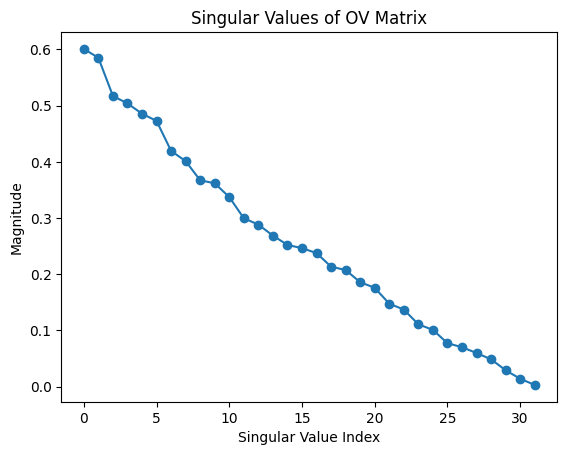

In [ ]:
import matplotlib.pyplot as plt

# Convert S to a NumPy array
S_numpy = S.detach().numpy()

# Plot singular values
plt.plot(S_numpy, marker="o")
plt.xlabel("Singular Value Index")
plt.ylabel("Magnitude")
plt.title("Singular Values of OV Matrix")
plt.show()



**Plotting RESULTS**

The plot reveals a steady decline in singular values, indicating that the first few components contribute the most to the OV matrix, while later ones have diminishing significance. This suggests that much of the transformer's behavior is captured by just a handful of dominant directions.

**VISUALIZING U AND V**

Now that we have computed the SVD of the OV matrix, we will visualize the top singular vectors to better understand the key directions in the transformation. The left singular vectors (U) capture how different input features contribute to these dominant transformations, while the right singular vectors (V) reveal the important output directions. By plotting heatmaps of the top five singular vectors, we can analyze which patterns the transformer prioritizes in its processing.

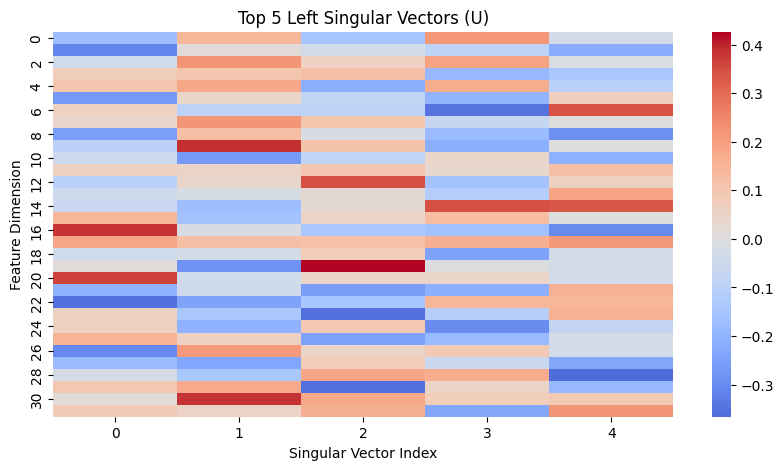

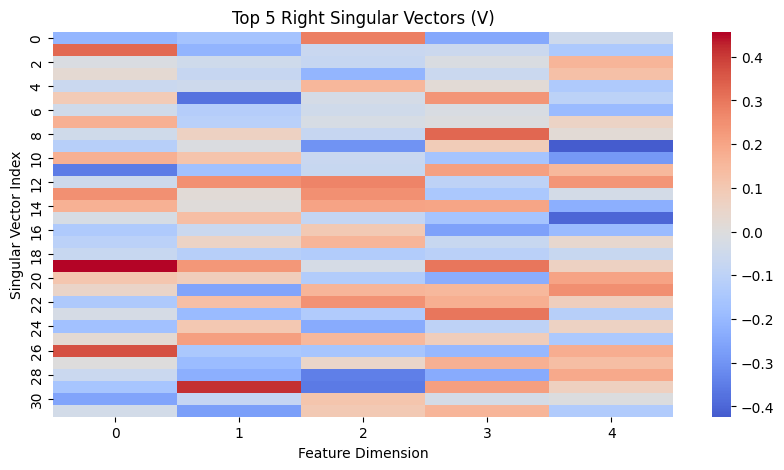

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PyTorch tensors to NumPy
U_np = U.detach().cpu().numpy()
Vt_np = Vt.detach().cpu().numpy()  # This is V transposed, so we need to transpose it back         #From Claude AI at 11:30 am 2/18/25

# Visualize the top left singular vectors (U)
plt.figure(figsize=(10, 5))
sns.heatmap(U_np[:, :5], cmap="coolwarm", center=0)  # Visualize first 5 columns of U
plt.title("Top 5 Left Singular Vectors (U)")
plt.xlabel("Singular Vector Index")
plt.ylabel("Feature Dimension")
plt.show()

# Visualize the top right singular vectors (V)
plt.figure(figsize=(10, 5))
sns.heatmap(Vt_np[:5, :].T, cmap="coolwarm", center=0)  # Transpose Vh to get V
plt.title("Top 5 Right Singular Vectors (V)")
plt.xlabel("Feature Dimension")
plt.ylabel("Singular Vector Index")
plt.show()


**U AND V HEATMAP EXPLANATION**

Based on the above heatmaps, we see that in the left singular vectors, we observe strong localized activations in certain feature dimensions, suggesting that specific input features play a dominant role in shaping the transformation applied by the OV circuit. Similarly, the right singular vectors exhibit structured patterns across different singular vector indices, indicating that the output space is influenced by a combination of learned transformations rather than a uniform distribution. The variation in intensity across both heatmaps implies that while some singular vectors contribute significantly to the transformation process, others have a more diffuse effect, aligning with the observed decay in singular values. This result highlights that the OV matrix does not distribute importance evenly across all directions but instead concentrates its transformations along a few dominant modes.

### **Reconstructing the OV Matrix with Top Singular Values**  

To further analyze the impact of singular values, we reconstruct an approximation of the OV matrix using only the top \( k \) singular values and their corresponding singular vectors. This allows us to assess how much of the original structure is retained with a limited number of dominant components. By visualizing the reconstructed matrix, we can see how well these top singular modes capture the key transformations performed by the OV circuit.

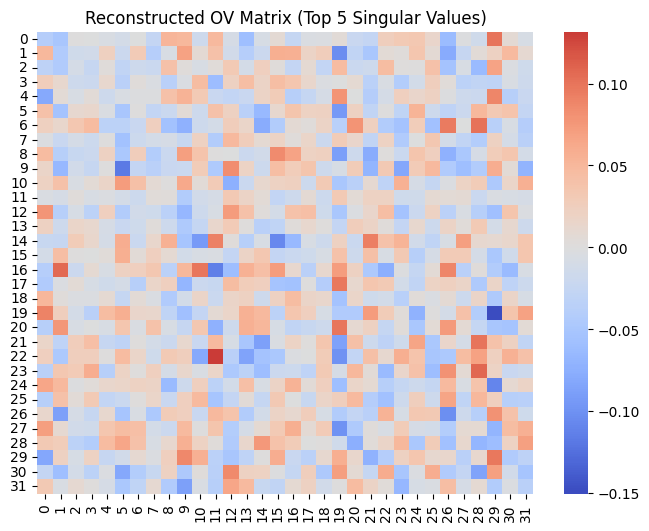

In [ ]:
k = 5
approx_OV = (U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]).detach().cpu().numpy()        #Modified from Claude AI at 12:23 pm 2/18/2025

plt.figure(figsize=(8, 6))
sns.heatmap(approx_OV, cmap="coolwarm", center=0)
plt.title(f"Reconstructed OV Matrix (Top {k} Singular Values)")
plt.show()

### **Reconstructing the OV Matrix with Top Singular Values Explanation**  

The reconstructed OV matrix using the top 5 singular values provides a low-rank approximation of the original structure, capturing the most dominant patterns while discarding less significant details. The heatmap reveals that key transformations are still present, as indicated by the distribution of positive and negative values, but much of the fine-grained information is lost. The patchy, dispersed nature of the visualization suggests that while the leading singular vectors retain the core structure, the omitted components contribute to more nuanced transformations. This demonstrates the balance between dimensionality reduction and the preservation of meaningful features in understanding the model’s learned representations.

### **Conclusion**

This project implemented key findings from A Mathematical Framework for Transformer Circuits by extracting and analyzing the OV matrix from a one-layer attention-only transformer. The paper describes how the OV matrix functions as a linear mapping that transforms attention outputs before they are passed to the next layer. Our approach closely followed this theoretical foundation by computing the singular value decomposition (SVD) of the OV matrix and examining its structure through singular values, left singular vectors, and right singular vectors. The results confirmed that the singular values decay gradually, indicating that the OV matrix can be effectively approximated using a lower-rank representation. This supports the claim that transformers rely on a small number of dominant transformations to encode relationships between tokens.

Through this process, we gained a deeper understanding of the role the OV matrix plays in attention computation. The SVD decomposition provided insight into how information is distributed across different singular modes, revealing that only a few dominant directions contribute significantly to the transformation process. This aligns with the broader theme in mechanistic interpretability that transformer circuits can often be understood in terms of simple linear algebraic operations.

One of the main challenges encountered in this project was ensuring that the extracted OV matrix conformed to expected dimensions and structure. Additionally, handling PyTorch tensors correctly, especially when transitioning between PyTorch and NumPy for visualization, required careful debugging. Another challenge was in interpreting the significance of the singular vectors beyond their mathematical properties—further analysis would be needed to tie them back to meaningful transformer behaviors.

A potential extension of this work would be to apply the same analysis to multi-layer or multi-head transformer models. This would allow us to examine whether similar low-rank properties hold across deeper architectures and how the OV matrix evolves as more layers are added. Additionally, incorporating mechanistic interpretability techniques such as probing individual attention heads for specific tasks could provide further insights into how transformers encode information in real-world language modeling scenarios.

By implementing and visualizing this key transformer circuit component, we have demonstrated a concrete example of how mechanistic interpretability can be applied to analyze and demystify modern deep learning architectures.




**SOURCES**

I have used / modified code from Claude AI. All instances of this have been noted in the comments of the code.